##Predict-Mexico-House-Price
____________________

##1) Environment set-up

In [1]:
from glob import glob
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split


#2) Importing Data

In [2]:
files = glob('/content/Data/mexico-city-real-estate-*.csv')
for i in files:
  print(i)

/content/Data/mexico-city-real-estate-1.csv
/content/Data/mexico-city-real-estate-5.csv
/content/Data/mexico-city-real-estate-4.csv
/content/Data/mexico-city-real-estate-3.csv
/content/Data/mexico-city-real-estate-2.csv


In [3]:
def Read(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    return df

In [4]:
frames = [Read(file) for file in files]

In [5]:
df = pd.concat(frames,ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23140 entries, 0 to 23139
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  23140 non-null  int64  
 1   operation                   23140 non-null  object 
 2   property_type               23140 non-null  object 
 3   place_with_parent_names     23140 non-null  object 
 4   lat-lon                     20698 non-null  object 
 5   price                       22745 non-null  float64
 6   currency                    22745 non-null  object 
 7   price_aprox_local_currency  22745 non-null  float64
 8   price_aprox_usd             22745 non-null  float64
 9   surface_total_in_m2         8633 non-null   float64
 10  surface_covered_in_m2       22215 non-null  float64
 11  price_usd_per_m2            6012 non-null   float64
 12  price_per_m2                21320 non-null  float64
 13  floor                       153

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


##3) Feature Engineering

In [6]:
# Focus on apartments in "Distrito Federal
# which cost less than $100000
mask_apt = df["place_with_parent_names"].str.contains("Distrito Federal")
mask_price = df['price_aprox_usd'] < 100000
mask_prt = df['property_type'] == "apartment"
df = df[mask_apt & mask_price & mask_prt]
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

<ipython-input-6-d870d9cc24bc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Unnamed: 0'],inplace=True)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
2,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.67000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
11,sell,apartment,|Benito Juárez|Distrito Federal|México|,"23.634501,-102.552788",1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.22807,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...
14,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.36269,-99.150565",1260000.0,MXN,1248601.52,66384.96,NaN,103.0,NaN,12233.00971,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/onph_ven...
20,sell,apartment,|Iztacalco|Distrito Federal|México|,"19.4024128,-99.0953907",1345000.0,MXN,1333148.73,70880.12,56.0,56.0,1265.716429,24017.85714,NaN,NaN,NaN,http://iztacalco.properati.com.mx/r6gm_venta_d...
21,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.35782,-99.149406",1295000.0,MXN,1283284.95,68228.99,NaN,80.0,NaN,16187.50000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/qvop_ven...


In [7]:
#separate lat & lon
df[['lat','lon']] = df['lat-lon'].str.split(',', expand= True).astype(float)
df.drop(columns = 'lat-lon', inplace= True)
# 4 - Create a "borough" feature
df['borough'] = df["place_with_parent_names"].str.split('|',expand= True )[1]
df.drop(columns = 'place_with_parent_names', inplace= True)


#Drop  NaN

In [8]:
def CountNull (df) :
  null = df.isna().sum()
  null_percent = 100 * df.isnull().sum()/len(df)
  null_table = pd.concat([null, null_percent], axis=1, keys=['Null Values', 'Null Values Percent %'])
  null_table = null_table[null_table.iloc[:,1] != 0].sort_values('Null Values Percent %', ascending=False).round(1)
  return null_table
CountNull(df)

,Null Values,Null Values Percent %
floor,6993,100.0
expenses,6992,100.0
rooms,6817,97.5
price_usd_per_m2,6325,90.4
surface_total_in_m2,6053,86.6
lat,475,6.8
lon,475,6.8
price_per_m2,265,3.8
surface_covered_in_m2,213,3.0


In [9]:
#Drop columns that are more than 50% null values
df.drop(columns = ['surface_total_in_m2','price_usd_per_m2','expenses','floor','rooms'], inplace= True)

##Leakage Feature
Since our purpose is to predict the price of house in Mexico so our target will be "price_aprox_usd" so every feature relate to money will have a strong correlation with the target feature so I will drop those columns express price of house in the DataFrame

Those columns are "price", "price_aprox_local_currency", "price_per_m2"

"Decision Making Based on Null Value Counts"



In [10]:
sorted(df.columns)

['borough',
 'currency',
 'lat',
 'lon',
 'operation',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'properati_url',
 'property_type',
 'surface_covered_in_m2']

In [11]:
df.drop(columns = ["price", "price_aprox_local_currency", "price_per_m2"],
        inplace = True)
df.head()

,operation,property_type,currency,price_aprox_usd,surface_covered_in_m2,properati_url,lat,lon,borough
2,sell,apartment,MXN,48822.82,100.0,http://tlalpan.properati.com.mx/qbi4_venta_dep...,19.279771,-99.234597,Tlalpan
11,sell,apartment,MXN,94022.66,57.0,http://benito-juarez.properati.com.mx/pdji_ven...,23.634501,-102.552788,Benito Juárez
14,sell,apartment,MXN,66384.96,103.0,http://benito-juarez.properati.com.mx/onph_ven...,19.362690,-99.150565,Benito Juárez
20,sell,apartment,MXN,70880.12,56.0,http://iztacalco.properati.com.mx/r6gm_venta_d...,19.402413,-99.095391,Iztacalco
21,sell,apartment,MXN,68228.99,80.0,http://benito-juarez.properati.com.mx/qvop_ven...,19.357820,-99.149406,Benito Juárez


#Exploring Cardinality in Categorical Data

In [12]:
df.select_dtypes('object').head()

,operation,property_type,currency,properati_url,borough
2,sell,apartment,MXN,http://tlalpan.properati.com.mx/qbi4_venta_dep...,Tlalpan
11,sell,apartment,MXN,http://benito-juarez.properati.com.mx/pdji_ven...,Benito Juárez
14,sell,apartment,MXN,http://benito-juarez.properati.com.mx/onph_ven...,Benito Juárez
20,sell,apartment,MXN,http://iztacalco.properati.com.mx/r6gm_venta_d...,Iztacalco
21,sell,apartment,MXN,http://benito-juarez.properati.com.mx/qvop_ven...,Benito Juárez


In [13]:
df.select_dtypes('object').nunique()
#there is two coloumns with  low cardinality so its not give any information so ~drop
#there is two coloumns with  very high cardinality so its not give any information so it case when use one hot encoder big proplem  ~drop

,0
operation,1
property_type,1
currency,2
properati_url,6993
borough,15


In [14]:
df.drop(columns = ["operation", "property_type", "currency", "properati_url"],
        inplace = True)
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
2,48822.82,100.0,19.279771,-99.234597,Tlalpan
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
14,66384.96,103.0,19.362690,-99.150565,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez


#Multicollinarity

<Axes: >

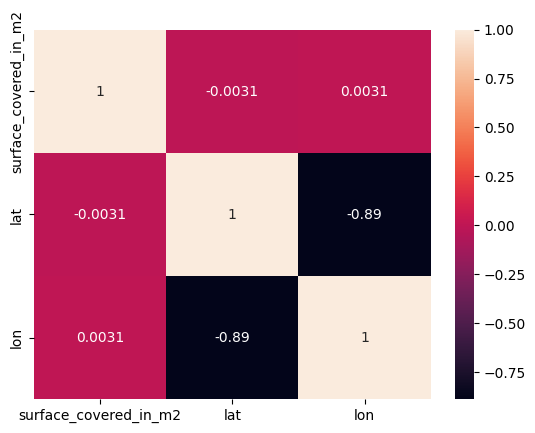

In [15]:
corr=df.drop(columns = ['borough',"price_aprox_usd"]).corr()
sns.heatmap(corr,annot=True)

#Managing Outliers

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price_aprox_usd,6993.0,54741.884263,21404.709267,7000.000000,38092.320000,51632.750000,71126.750000,9.986456e+04
surface_covered_in_m2,6780.0,10415.101180,799078.776852,0.000000,56.000000,65.000000,79.000000,6.574800e+07
lat,6518.0,19.458106,0.493089,19.194247,19.365917,19.400731,19.448187,2.363450e+01
lon,6518.0,-99.186332,0.439657,-102.552788,-99.178566,-99.146127,-99.121407,-9.048847e+01


In [17]:
low ,high = df['surface_covered_in_m2'].quantile([0.1,0.9])
mask_area = df['surface_covered_in_m2'].between(low, high)
df = df[mask_area]
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5472 entries, 11 to 23135
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5472 non-null   float64
 1   surface_covered_in_m2  5472 non-null   float64
 2   lat                    5147 non-null   float64
 3   lon                    5147 non-null   float64
 4   borough                5472 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB


##4) Split Data

In [19]:
# Split data into feature matrix `X_train` and target vector `y_train`.
features = ['surface_covered_in_m2','lat','lon','borough']
target = "price_aprox_usd"
X_train = df[features]
y_train = df[target]

In [20]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
baseline_mae = mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54202.19800255847
Baseline MAE: 17206.49869506523


## 5 )Build Model

In [27]:
# Build Model
model=make_pipeline(OneHotEncoder(),
                    SimpleImputer(),
                    Ridge())
# Fit model
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5472 entries, 11 to 23135
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  5472 non-null   float64
 1   lat                    5147 non-null   float64
 2   lon                    5147 non-null   float64
 3   borough                5472 non-null   object 
dtypes: float64(3), object(1)
memory usage: 213.8+ KB


In [25]:
X_test = pd.read_csv('/content/Data/mexico-city-test-features.csv')
x_test = X_test.drop(columns = ["Unnamed: 0"],inplace = True)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB


In [28]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

,0
0,36401.241367
1,55364.910756
2,19917.513042
3,35369.125912
4,77183.923254


In [29]:
def make_prediction(area, lat, lon, borough):
    data = {'surface_covered_in_m2': area
            , 'lat':lat
            , 'lon':lon
            , 'borough':borough}
    df = pd.DataFrame(data,index = [0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"


In [30]:
make_prediction(110, -34.60, -58.46, "Benito Juárez")

'Predicted apartment price: $70849.93'

In [31]:

interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=90, min=48), FloatSlider(value=19.4532547421…